In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
from tqdm import tqdm
import statsmodels.api as smf
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import display_html
import plotly.offline as pyo

### Load the data and preprocess it

abreviation dictionnary:  
    cc = climate change  
    vids = videos  
    ch = channels  

In [2]:
climate_videos_df = pd.read_json("data/climate_videos_v3.jsonl", lines=True)
climate_videos_df.dropna(inplace=True, subset='view_count')
climate_videos_df.sort_values(by='view_count', inplace=True, ascending=False)
climate_videos_df.rename(columns={'channel_id': 'channel'}, inplace=True)
climate_videos_df.drop(columns=['crawl_date', 'duration'], inplace=True)

In [3]:
ch_df = pd.read_csv('data/df_channels_en.tsv', delimiter='\t')
ch_df.rename(columns={'category_cc': 'category', 'name_cc': 'name', 'subscribers_cc': 'subs', 'videos_cc': 'vids_count'}, inplace=True)
ch_df.drop(columns=['subscriber_rank_sb', 'weights', 'join_date'], inplace=True)
ch_df.set_index('channel', inplace=True)
ch_df.head(3)

,category,name,subs,vids_count
channel,,,,
UC-lHJZR3Gqxm24_Vd_AJ5Yw,Gaming,PewDiePie,101000000,3956
UCbCmjCuTUZos6Inko4u57UQ,Education,Cocomelon - Nursery ...,60100000,458
UCpEhnqL0y41EpW2TvWAHD7Q,Entertainment,SET India,56018869,32661


In [4]:
cc_vids_df = climate_videos_df.merge(ch_df[['name', 'subs']], on ='channel', how ='left').fillna(0)
cc_vids_df.set_index('display_id', inplace=True)
display(cc_vids_df.head(3))

,categories,channel,description,dislike_count,like_count,tags,title,upload_date,view_count,classification_categories,name,subs
display_id,,,,,,,,,,,,
cFAylV8Wkwk,Science & Technology,UC3O8-tKnz9VUn3sxZKyKN3w,India is amongst the top 5 countries in e-wast...,435.0,2302.0,"save environment,clean india,e waste,samsung v...",Samsung Care For Clean India Program,2019-07-28 00:00:00,144849603,{'/Computers & Electronics/Consumer Electronic...,SamsungIndia,4010000
QN7BFBqZ6qo,Entertainment,UCxo37Wc-azMveu1NXiCcAFA,While many of you may have asked who is Suraj ...,73761.0,299040.0,"Suraj,Chakravarti,Viral,Funny,Hitachi AC,Funny...",Know the reason for extreme heat this summer! ...,2018-05-29 00:00:00,110302967,{'/Science/Ecology & Environment/Climate Chang...,Hitachi Cooling & He...,249000
677R2ezfAT8,Nonprofits & Activism,UCTZmwwn0Wd5YsAxw0NZzyJA,Water is the world’s most precious resource. N...,51125.0,112417.0,"WWF,WWF-Pakistan,World Water Week,Freshwater,S...",Elephant vs Giraffe Water Fight,2018-08-27 00:00:00,87753613,"{'/Pets & Animals/Wildlife': 0.8440645337, '/P...",WWF - Pakistan,170000


In [5]:
timeseries_df = pd.read_csv('DATA/df_timeseries_en.tsv', delimiter='\t')
timeseries_df = timeseries_df.sort_values(by='datetime', ascending=True)
display(timeseries_df.head(2))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
8698774,UC1Ru5ZqoiF1cFwQSuFuv-KA,Gaming,2015-01-05 00:00:00,3111235.0,0.0,16818.0,0.0,0,0,0
2462377,UCnYwVM9uyLGzTFfAkWqiUdQ,Gaming,2015-01-05 00:00:00,25800145.0,0.0,70829.0,0.0,1420,0,20


## Are videos about climate change popular ?

- Do climate change videos have more views than others ?

In [6]:
# adds a column that counts the ratio of climate videos to total videos
ratios = cc_vids_df['channel'].value_counts().reset_index()
ratios.columns = ['channel', 'cc_vids_count']
ch_cc_df = ch_df.merge(ratios, on ='channel', how ='left').fillna(0)
ch_cc_df['proportion_cc_vids'] = ch_cc_df['cc_vids_count']/ch_cc_df['vids_count']

display(ch_cc_df.head(3))

,channel,category,name,subs,vids_count,cc_vids_count,proportion_cc_vids
0,UC-lHJZR3Gqxm24_Vd_AJ5Yw,Gaming,PewDiePie,101000000,3956,0.0,0.0
1,UCbCmjCuTUZos6Inko4u57UQ,Education,Cocomelon - Nursery ...,60100000,458,0.0,0.0
2,UCpEhnqL0y41EpW2TvWAHD7Q,Entertainment,SET India,56018869,32661,0.0,0.0


In [7]:
# df with the metadata of all channels
ch_stats_df = timeseries_df[['channel', 'views', 'videos']].groupby('channel').last()

# df with the metadata of channels with climate videos
ch_cc_stats_df = cc_vids_df[['channel', 'view_count']].groupby('channel').agg(['sum', 'count'])
ch_cc_stats_df.columns = ch_cc_stats_df.columns.to_flat_index()
ch_cc_stats_df.rename(columns={('view_count', 'sum'): 'cc_views', ('view_count', 'count'): 'cc_videos'}, inplace=True)

# df with only climate change channels and their stats on with and without climate videos
ch_cc_stats_df = ch_stats_df.merge(ch_cc_stats_df, how='inner', on='channel')
ch_cc_stats_df['avg_views_wo_cc'] = (ch_cc_stats_df['views'] - ch_cc_stats_df['cc_views'])/(ch_cc_stats_df['videos'] - ch_cc_stats_df['cc_videos'])
ch_cc_stats_df['avg_views_w_cc'] = ch_cc_stats_df['cc_views']/ch_cc_stats_df['cc_videos']
ch_cc_stats_df['avg_views'] = ch_cc_stats_df['views']/ch_cc_stats_df['videos']

# remove odd values
ch_cc_stats_df = ch_cc_stats_df[ch_cc_stats_df['cc_videos']<ch_cc_stats_df['videos']].dropna()
ch_cc_stats_df = ch_cc_stats_df[ch_cc_stats_df['avg_views_wo_cc']>0].dropna()

display(ch_cc_stats_df.head(2))

,views,videos,cc_views,cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views
channel,,,,,,,
UC--70ql_IxJmhmqXqrkJrWQ,2.070418e+07,243,7604,1,85523.031877,7604.0,85202.377425
UC-1rx8j9Ggp8mp4uD0ZdEIA,9.329747e+08,4190,10305,1,222717.680115,10305.0,222666.984964


In [8]:
model = smf.formula.ols(formula='avg_views_wo_cc ~ avg_views_w_cc', data=ch_cc_stats_df, missing='drop').fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        avg_views_wo_cc   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     1570.
Date:                Fri, 22 Dec 2023   Prob (F-statistic):          1.40e-303
Time:                        22:58:33   Log-Likelihood:                -86089.
No. Observations:                5725   AIC:                         1.722e+05
Df Residuals:                    5723   BIC:                         1.722e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1.123e+05   1.09e+04     10.

In [9]:
ch_cc_df = ch_cc_stats_df.merge(ch_cc_df[['channel', 'name', 'subs', 'proportion_cc_vids']], on ='channel', how ='inner').fillna(0)
ch_cc_df.set_index('name', inplace=True)

# df with channels that have more than 50% of their videos on climate change
ch_50cc_df = ch_cc_df[ch_cc_df['proportion_cc_vids']>=0.5].sort_values(by='proportion_cc_vids', ascending=False)
display(ch_50cc_df)

,channel,views,videos,cc_views,cc_videos,avg_views_wo_cc,avg_views_w_cc,avg_views,subs,proportion_cc_vids
name,,,,,,,,,,
Rob Greenfield,UCKirXBZV7hE4Fws3VSdYkRQ,5.506280e+06,206,5008132,161,11069.949206,31106.409938,26729.513176,116000,0.763033
The YEARS Project,UCxJf58pbfCYiDOKxRTJI9cA,3.098489e+06,494,2795338,338,1943.276366,8270.230769,6272.245168,21700,0.686992
1000frolly PhD,UCAR0Oi4L0Om4F26uwpANgCg,1.034144e+07,167,9356772,106,16142.053864,88271.433962,61924.774166,31300,0.634731
Climate Reality,UCIJk74xZtFZut1rJVHVVXeA,4.029099e+06,522,3174000,320,4233.162659,9918.750000,7718.580186,15655,0.613027
Just Have a Think,UCRBwLPbXGsI2cJe9W1zfSjQ,1.362583e+06,75,818670,43,16997.278088,19038.837209,18167.771984,29500,0.581081
Guy Brown,UCa5FbtOmZvP0Z6wR4n7jL8w,5.032664e+06,624,1694718,353,12317.145493,4800.900850,8065.167353,26200,0.564800
Our Changing Climate...,UCNXvxXpDJXp-mZu3pFMzYHQ,8.013691e+06,78,3628840,44,128966.198004,82473.636364,102739.624771,171000,0.556962
Climate State,UCXy9Efp5QoTGGxmpKBujLLQ,7.079024e+06,45,778977,30,420003.103030,25965.900000,157311.634343,28700,0.555556
Friends of Science,UCSjTdgNgUW7VNfemabYV3Kg,1.643781e+06,308,1289450,170,2567.616977,7585.000000,5336.951763,13800,0.551948


In [10]:
colors = ['darkgrey', 'forestgreen']
colors_ch = ['#238823', '#299A29', '#2FA12F', '#36A936', '#3CAF3C', '#43B643', '#49BD49', '#50C450', '#56CA56', '#5DD15D']

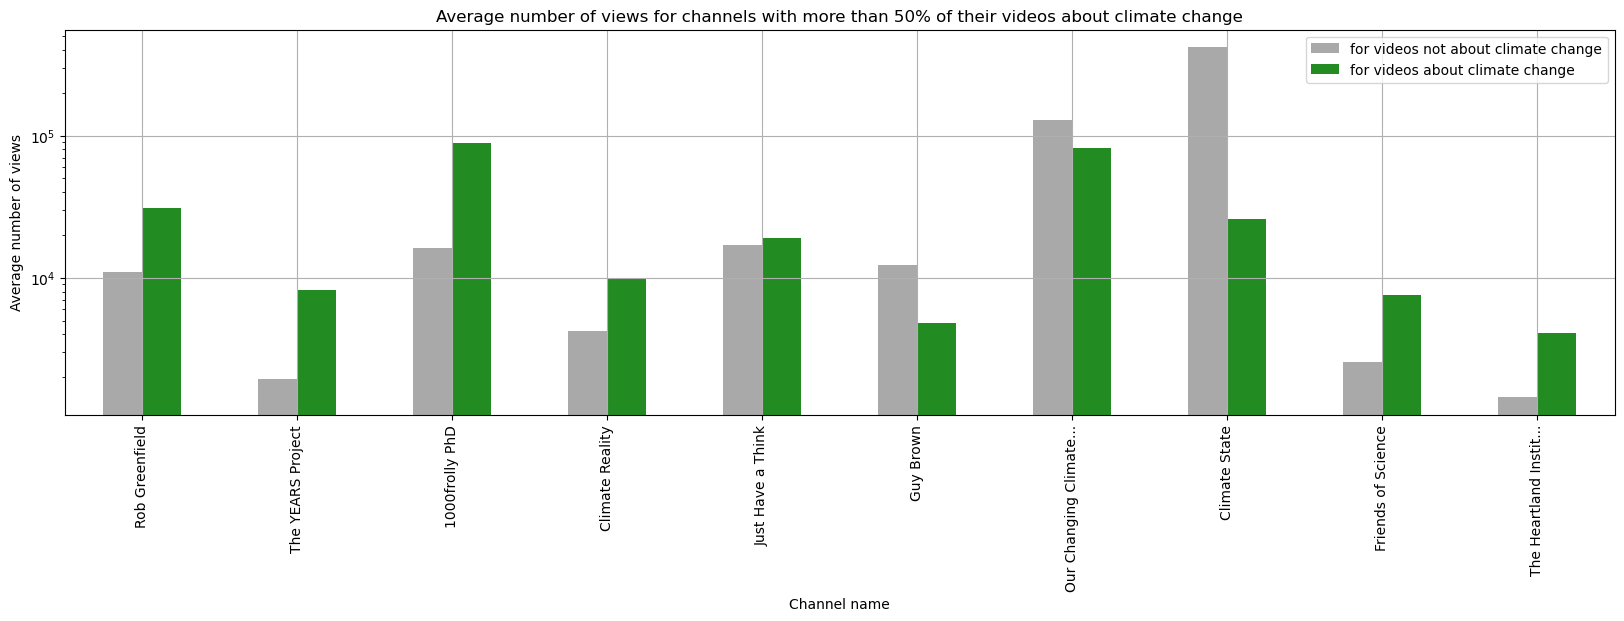

In [11]:
fig, ax = plt.subplots(figsize = (20, 5))

ch_50cc_df[['avg_views_wo_cc', 'avg_views_w_cc']].plot(kind='bar', grid=True, ax=ax, color=[colors[0], colors[1]])

ax.set_yscale("log")
plt.title('Average number of views for channels with more than 50% of their videos about climate change')
plt.legend(['for videos not about climate change', 'for videos about climate change'], loc='upper right')
plt.ylabel('Average number of views')
plt.xlabel('Channel name')
plt.show()

Text(0.5, 0, 'Average number of views for videos about climate change')

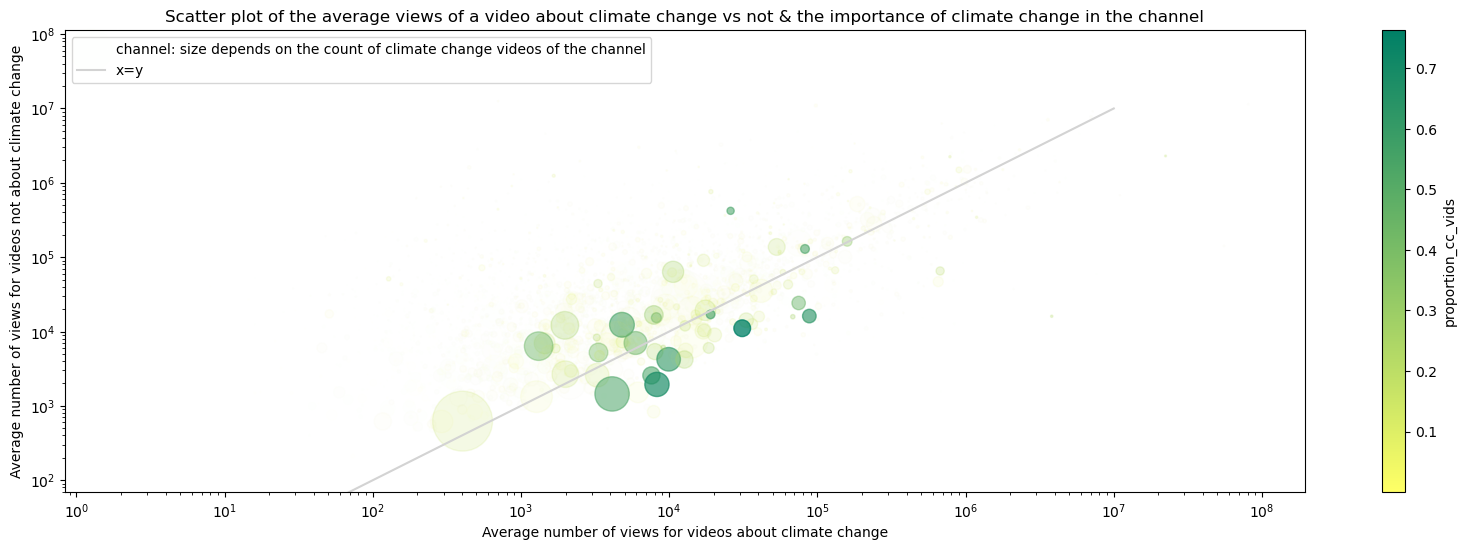

In [12]:
fig, ax = plt.subplots(figsize = (20, 6))

ch_cc_df.plot.scatter(x='avg_views_w_cc', y='avg_views_wo_cc', s=ch_cc_df['cc_videos']*0.9, ax=ax, 
                       c='proportion_cc_vids', colormap='summer_r', alpha=ch_cc_df['proportion_cc_vids'])

x = range(0, 10**7, 1000)
plt.plot(x, x, color='lightgray')

ax.set_xscale("log")
ax.set_yscale("log")

plt.title('Scatter plot of the average views of a video about climate change vs not & the importance of climate change in the channel')
plt.legend(['channel: size depends on the count of climate change videos of the channel', 'x=y'], loc='upper left')
plt.ylabel('Average number of views for videos not about climate change')
plt.xlabel('Average number of views for videos about climate change')

In [38]:
fig = px.scatter(ch_cc_df, x='avg_views_w_cc', y='avg_views_wo_cc',
                 size='cc_videos', color='proportion_cc_vids',
                 color_continuous_scale='RdYlGn',
                 opacity=ch_cc_df['proportion_cc_vids'],
                 labels={'avg_views_w_cc': 'Average views for videos about climate change',
                         'avg_views_wo_cc': 'Average views for videos not about climate change',
                         'proportion_cc_vids': 'Ratio'},
                 title='Repartition of channels containing videos about climate change',
                 hover_name=ch_cc_df.index)

fig.add_trace(go.Scatter(x=[0, 10**7], y=[0, 10**7], mode='lines', line=dict(color='lightgray'),
                         name='x=y'))

fig.update_layout(
    xaxis_type="log",
    yaxis_type="log",
    legend=dict(x=0, y=1, traceorder='normal', orientation='h'),
    width=800,
    height=400,
    xaxis_title='Average nb of views for climate change videos',
    yaxis_title='Avg nb of views for not climate change videos',
    margin=dict(l=5, r=0, t=50, b=5)
)

pyo.plot(fig, filename='html_plots/scatter_inter.html')

fig.show()


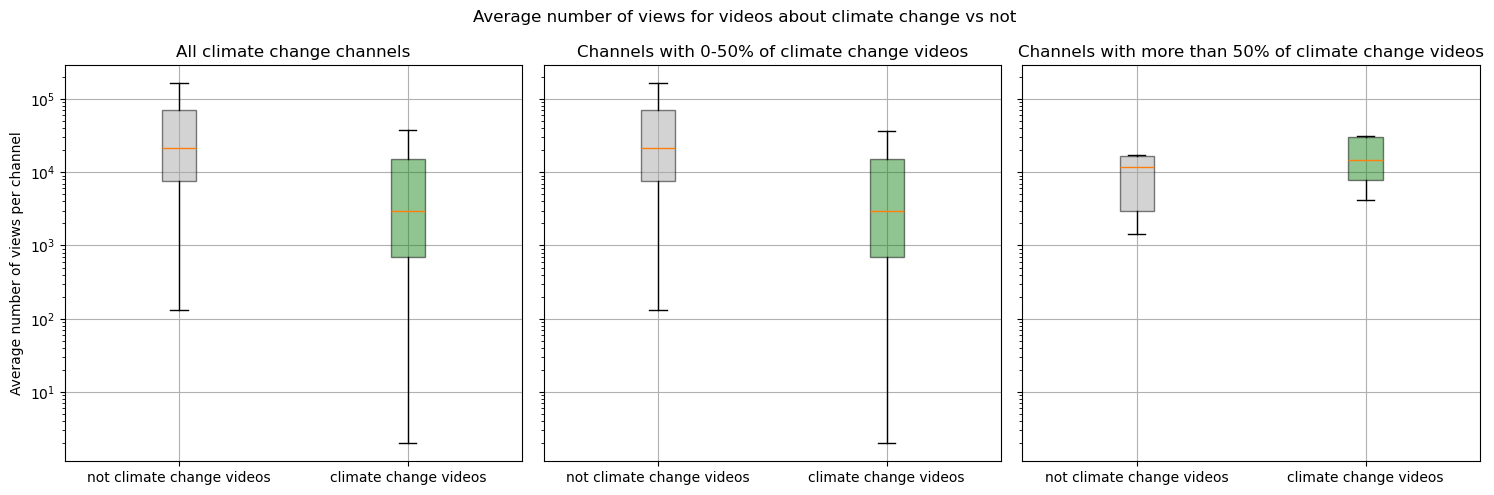

In [14]:
ch_cc_df_first = ch_cc_df[ch_cc_df['proportion_cc_vids'] <= 0.5].dropna()
ch_cc_df_second = ch_cc_df[ch_cc_df['proportion_cc_vids'] > 0.5].dropna()

fig, (pA, pB, pC) = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
labels = ['not climate change videos', 'climate change videos']

a = pA.boxplot(ch_cc_df[['avg_views_wo_cc', 'avg_views_w_cc']], patch_artist=True, showfliers=False, labels=labels)
b = pB.boxplot(ch_cc_df_first[['avg_views_wo_cc', 'avg_views_w_cc']], patch_artist=True, showfliers=False, labels=labels)
c = pC.boxplot(ch_cc_df_second[['avg_views_wo_cc', 'avg_views_w_cc']], patch_artist=True, showfliers=False, labels=labels)

for x in [a, b, c]:
    for patch, color in zip(x['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)

pA.set_yscale("log")
fig.suptitle('Average number of views for videos about climate change vs not')
titles = ['All climate change channels', 'Channels with 0-50% of climate change videos', 'Channels with more than 50% of climate change videos']
for(ax, title) in zip([pA, pB, pC], titles):
    ax.set_title(title)
    ax.grid()
pA.set_ylabel('Average number of views per channel')
fig.tight_layout()
plt.show()

## Are people watch videos about climate change after events related to it ?

In [15]:
climate_events = pd.read_csv('data/climate_events_v2.csv')
climate_events['date'] = pd.to_datetime(climate_events['date'])
climate_events.set_index('date', inplace=True)

In [16]:
ch_cc_df_second.reset_index(inplace=True)
timeseries_cc_df = timeseries_df.merge(ch_cc_df_second[['name', 'channel', 'proportion_cc_vids']], how='inner', on='channel')
timeseries_cc_df['datetime'] = pd.to_datetime(timeseries_cc_df['datetime'])
display(timeseries_cc_df)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,name,proportion_cc_vids
0,UCxJf58pbfCYiDOKxRTJI9cA,News & Politics,2016-03-14 00:00:00,1.790343e+06,2277.750000,12214.250000,0.000000,51,0,0,The YEARS Project,0.686992
1,UCxJf58pbfCYiDOKxRTJI9cA,News & Politics,2016-03-21 00:00:00,1.792948e+06,2604.875000,12239.125000,24.875000,51,0,0,The YEARS Project,0.686992
2,UCxJf58pbfCYiDOKxRTJI9cA,News & Politics,2016-03-28 01:00:00,1.795219e+06,2271.437827,12262.062827,22.937827,51,0,0,The YEARS Project,0.686992
3,UCxJf58pbfCYiDOKxRTJI9cA,News & Politics,2016-04-04 01:00:00,1.797427e+06,2207.775714,12281.604167,19.541339,51,0,0,The YEARS Project,0.686992
4,UCxJf58pbfCYiDOKxRTJI9cA,News & Politics,2016-04-11 01:00:00,1.799918e+06,2490.869792,12298.338542,16.734375,51,0,0,The YEARS Project,0.686992
...,...,...,...,...,...,...,...,...,...,...,...,...
1588,UCRBwLPbXGsI2cJe9W1zfSjQ,People & Blogs,2019-09-02 01:00:00,1.203208e+06,32475.863636,28421.964015,406.318182,71,2,2,Just Have a Think,0.581081
1589,UCRBwLPbXGsI2cJe9W1zfSjQ,People & Blogs,2019-09-09 01:00:00,1.235684e+06,32475.863636,28828.282197,406.318182,72,1,3,Just Have a Think,0.581081
1590,UCRBwLPbXGsI2cJe9W1zfSjQ,People & Blogs,2019-09-16 01:00:00,1.267327e+06,31642.974116,29202.083333,373.801136,72,0,1,Just Have a Think,0.581081
1591,UCRBwLPbXGsI2cJe9W1zfSjQ,People & Blogs,2019-09-23 01:00:00,1.298360e+06,31033.333333,29552.083333,350.000000,74,2,2,Just Have a Think,0.581081


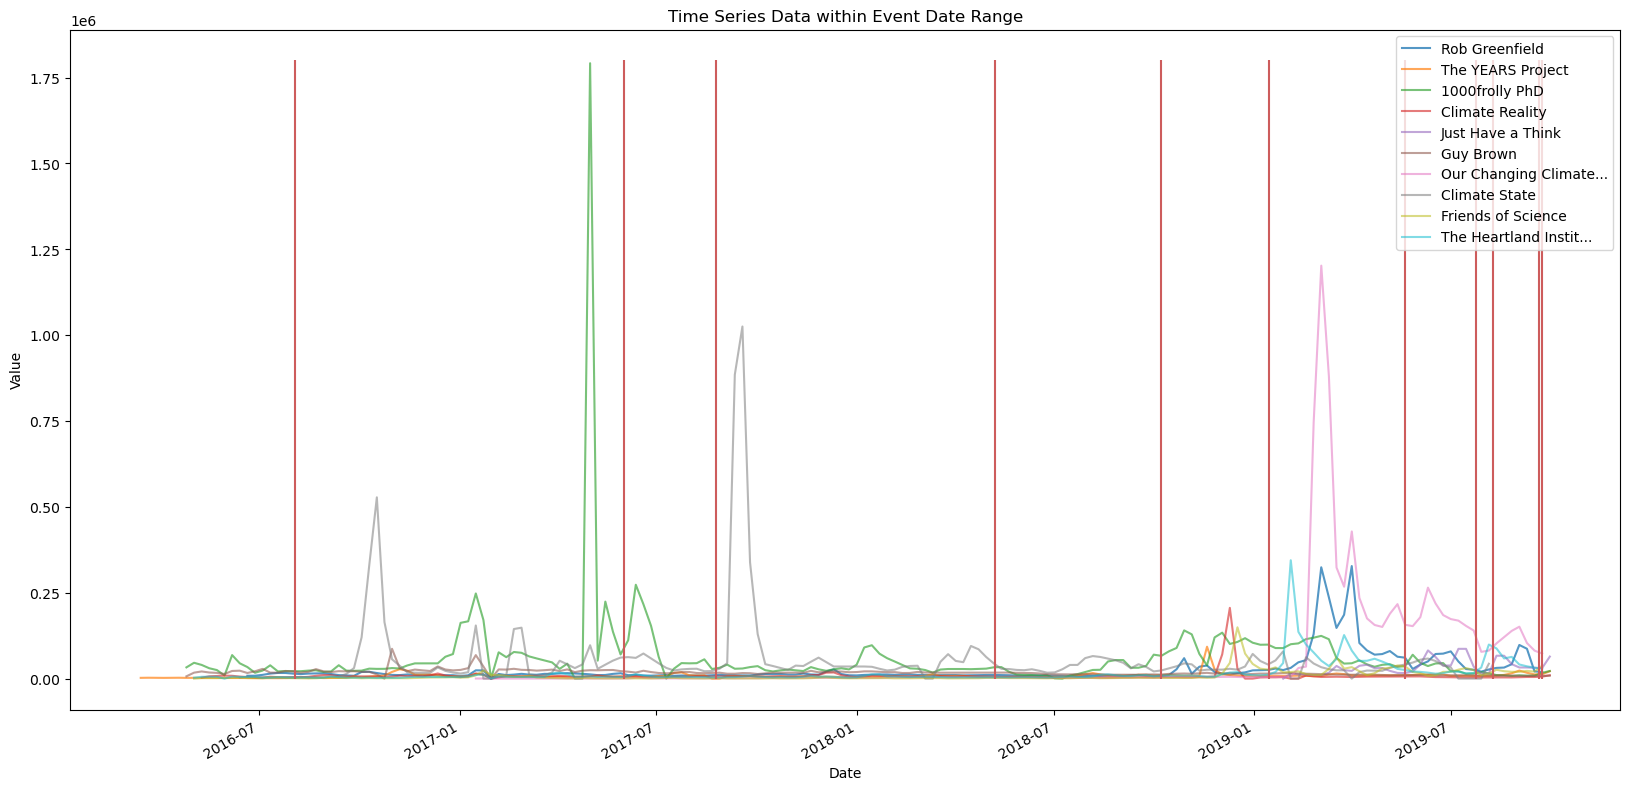

In [17]:
ch_cc_df_second.sort_values(by='proportion_cc_vids', ascending=False, inplace=True)
ch_list_second = ch_cc_df_second.channel.unique()
ch_list_df_second = [timeseries_cc_df[timeseries_cc_df['channel'] == channel].copy() for channel in ch_list_second]

fig = plt.figure(figsize=(20, 10))

for ch in ch_list_df_second:
    ch['datetime'] = pd.to_datetime(ch['datetime'])
    ch.set_index('datetime', inplace=True)
    ch['delta_views'].plot(label=ch['name'].iloc[0], legend=True, alpha=ch['proportion_cc_vids'].iloc[0])

plt.vlines(climate_events.loc['2016':'2019-10'].index, 0, ymax=1800000, colors='indianred', label="Important events")

#plt.yscale("log")
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Time Series Data within Event Date Range')
plt.show()

In [39]:
ch_list_second = ch_cc_df_second.channel.unique()
ch_list_df_second = [timeseries_cc_df[timeseries_cc_df['channel'] == channel].copy() for channel in ch_list_second]

colors = plt.cm.viridis(np.linspace(0, 1, len(ch_list_second)))

fig = go.Figure()

for ch, color in zip(ch_list_df_second, colors):
    ch['datetime'] = pd.to_datetime(ch['datetime'])
    ch.set_index('datetime', inplace=True)
    fig.add_trace(go.Scatter(x=ch.index, y=ch['delta_views'],
                             mode='lines',
                             name=ch['name'].iloc[0],
                             line=dict(width=2, color=f'rgba{tuple(int(255 * c) for c in color[:3])}')))

for y in range(200000, 2000000, 200000):
    for event_date in climate_events.loc['2016':'2019-10'].index:
        fig.add_trace(go.Scatter(x=[event_date, event_date], y=[0, y],
                                 mode='lines',
                                 line=dict(color='indianred', width=2),
                                 hoverinfo='text',
                                 text=f'Event: {climate_events.loc[event_date]["name"]}',
                                 showlegend=False)) 

fig.update_layout(
    xaxis=dict(title='Date'),
    yaxis=dict(title='Number of views'),
    title='Views per day for the channels that are involved with climate change',
    showlegend=True,
    legend=dict(x=1.01, y=0.5, traceorder='normal', orientation='v'),
    autosize=False,
    width=800,
    height=400,
    margin=dict(l=5, r=0, t=50, b=5)
)

pyo.plot(fig, filename='html_plots/timeseries_event.html')

fig.show()

In [19]:
cch_vids_date_df = cc_vids_df[['name', 'upload_date', 'title', 'description', 'tags', 'view_count']]
display(cch_vids_date_df.loc[cch_vids_date_df['name'] == '1000frolly PhD'].sort_values(by='view_count', ascending=False)['title'].head(5))

display_id
TCy_UOjEir0       Nobel Laureate Smashes the Global Warming Hoax
SXxHfb66ZgM    Nobel Laureate in Physics; "Global Warming is ...
C35pasCr6KI    Climate Scientists Laugh at Global Warming Hys...
BiKfWdXXfIs    Freeman Dyson on the Global Warming Hysteria A...
eiPIvH49X-E    Global Warming; 31,487 Scientists say NO to Alarm
Name: title, dtype: object

Most of the videos of the channels that are involved with climate change do not make videos about specific events and when they do, it is months after the event and they usually don't have many views. Therefore, that explains why we don't observe pics of views on those channels after an climate event.